In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset, DataLoader
from argparse import Namespace
%matplotlib inline

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
from cassava.utils import *
from cassava.transforms import get_test_transforms, get_train_transforms
from cassava.models.model import LeafDoctorModel
from cassava.pipelines.train_model.nodes import score_model
from cassava.pipelines.train_model.nodes import split_data, train_model

In [19]:
!pip install captum

You should consider upgrading via the '/home/boris/Documents/kaggle cassava/venv/bin/python3 -m pip install --upgrade pip' command.


In [20]:
from captum.attr import GuidedGradCam,  DeepLift, Occlusion, NoiseTunnel, IntegratedGradients
from captum.attr import visualization as viz

In [21]:
parameters = context.catalog.load('parameters')

2020-12-30 15:19:16,038 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [22]:
train = context.catalog.load('train')

2020-12-30 15:19:16,084 - kedro.io.data_catalog - INFO - Loading data from `train` (ImageOneFolderDataSet)...


In [23]:
train.labels = (train.sources == 'train_2020').astype(int)

In [24]:
train_idx, test_idx = train_test_split(range(len(train)), stratify=train.labels, random_state=42)
len(train_idx), len(test_idx)

(19749, 6583)

In [25]:
pd.Series(train.labels[test_idx]).value_counts()

1    5349
0    1234
dtype: int64

In [26]:
train_transforms = get_train_transforms(parameters['classifier']['train_width'], parameters['classifier']['train_height'])
test_transforms = get_test_transforms(parameters['classifier']['test_width'], parameters['classifier']['test_height'])

In [27]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [28]:
test = DatasetFromSubset(Subset(train, indices=test_idx))

In [29]:
train = DatasetFromSubset(Subset(train, indices=train_idx))

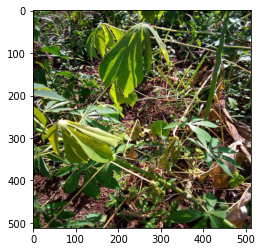

In [32]:
plt.imshow(train[0][0])

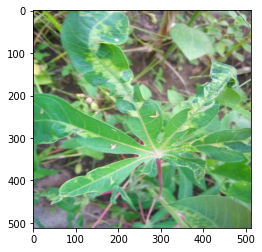

In [33]:
plt.imshow((test[0][0]))

# Train model to predict which dataset a picture came from

In [34]:
hparams = Namespace(**parameters['classifier'])
model = LeafDoctorModel(hparams)

In [35]:
model = train_model(model, train, parameters)

2020-12-30 15:19:37,745 - root - INFO - Training model


GPU available: True, used: True


2020-12-30 15:19:37,797 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-30 15:19:37,799 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-30 15:19:37,800 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-30 15:19:37,802 - lightning - INFO - Using native 16bit precision.


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-30 15:19:41,085 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)



2020-12-30 15:27:44,555 - root - INFO - Training finished


Test accuracy

In [36]:
score_model(model, test, list(range(len(test))), parameters)[0]

2020-12-30 15:27:44,563 - root - INFO - Scoring model



2020-12-30 15:28:40,833 - root - INFO - Validation scores:
{'accuracy': 0.8885006835789154, 'f1_score': 0.8837802735091916}


{'accuracy': 0.8885006835789154, 'f1_score': 0.8837802735091916}

# Interpret this craziness

## Applying guided grad CAM

In [37]:
model = model.eval()
model = model.cpu()

In [39]:
def get_attribution(model, image, source, label):
    prep_image_batch = image.unsqueeze(0)
    prediction = model.predict(prep_image_batch)[0]
    
    print('True:', source)
    print('Pred:', 'train_2020' if prediction else 'train_2019')

    n_samples = 10

#     attributor = GuidedGradCam(model, model.trunk.blocks[6][0].conv_pwl)
#     attributor = NoiseTunnel(attributor)
#     attribution = attributor.attribute(prep_image_batch,
#                                        target=target,
#                                       n_samples=n_samples)


    attributor = DeepLift(model)
    attributor = NoiseTunnel(attributor)
    attribution = attributor.attribute(prep_image_batch,
                                       target=target,
                                      baselines=0, n_samples=n_samples)



    # attributor = Occlusion(model)
    # strides = (3, 5, 5) 
    # sliding_window_shapes=(3,50,50)
    # target = int(label)
    # baselines = 0

    # attribution = attributor.attribute(prep_image_batch,
    #                                    target=target,
    #                                    sliding_window_shapes=sliding_window_shapes,
    #                                    strides=strides,
    #                                    baselines=baselines)

    attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))
    return attribution

def visualize_attribution(image, attribution):
    vis_types = ["heat_map", "blended_heat_map", "original_image"]
    vis_signs = ["all", "all", "all"] # "positive", "negative", or "all" to show both
    # positive attribution indicates that the presence of the area increases the prediction score
    # negative attribution indicates distractor areas whose absence increases the score

    _ = viz.visualize_image_attr_multiple(attribution,
                                          unnorm(image.clone()).permute((1, 2, 0)).numpy(),
                                          vis_types,
                                          vis_signs,
                                          vis_types,
                                          show_colorbar = True,
                                          fig_size=(20, 10)
                                         )

### Random train image

In [40]:
indices_2019 = np.argwhere(train.subset.dataset.sources[train.subset.indices] == 'train_2019').flatten()
indices_2020 = np.argwhere(train.subset.dataset.sources[train.subset.indices] == 'train_2020').flatten()

True: train_2019
Pred: train_2019


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


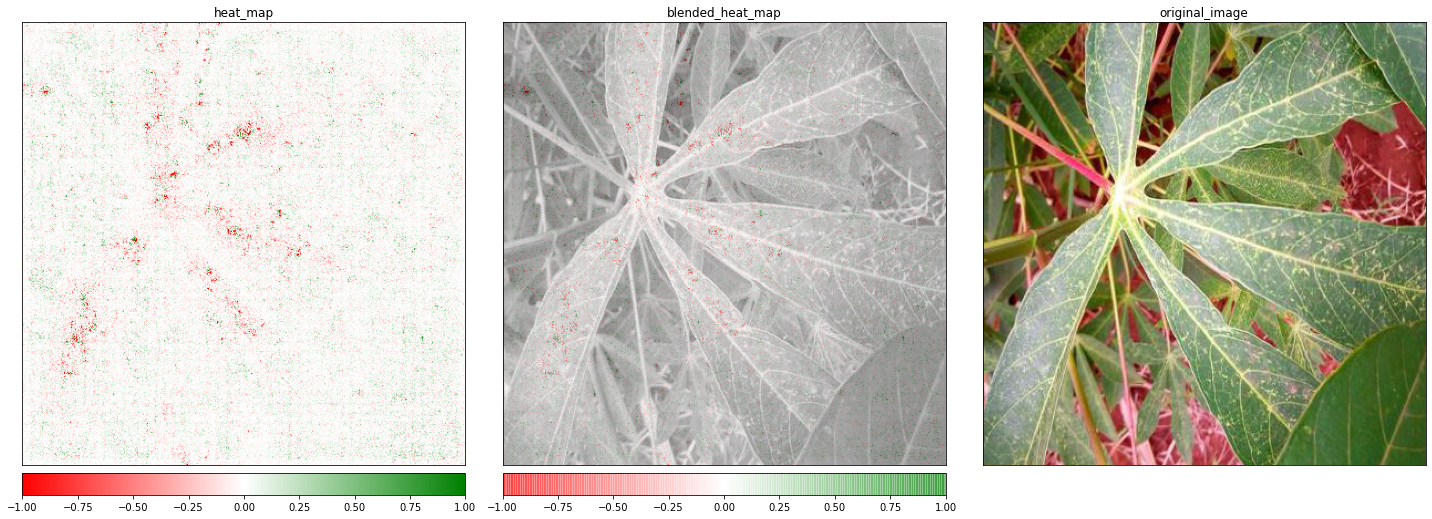

In [43]:
idx = np.random.choice(indices_2019)
source = train.subset.dataset.sources[train.subset.indices][idx]

image, label = train[idx]
prep_image = test_transforms(image)
target = int(label)

attribution = get_attribution(model, prep_image, source, label)

visualize_attribution(prep_image, attribution)


True: train_2020
Pred: train_2020


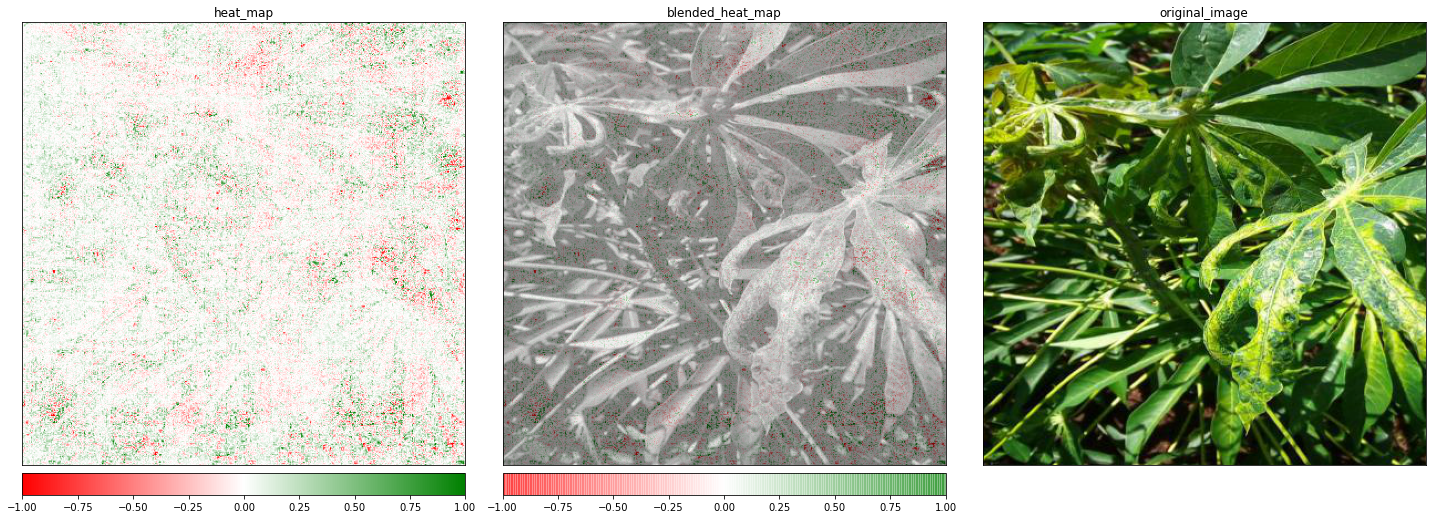

In [44]:
idx = np.random.choice(indices_2020)
source = train.subset.dataset.sources[train.subset.indices][idx]

image, label = train[idx]
prep_image = test_transforms(image)
target = int(label)

attribution = get_attribution(model, prep_image, source, label)

visualize_attribution(prep_image, attribution)


### Random test image

In [45]:
indices_2019_test = np.argwhere(test.subset.dataset.sources[test.subset.indices] == 'train_2019').flatten()
indices_2020_test = np.argwhere(test.subset.dataset.sources[test.subset.indices] == 'train_2020').flatten()

train_2019
True: train_2019
Pred: train_2019


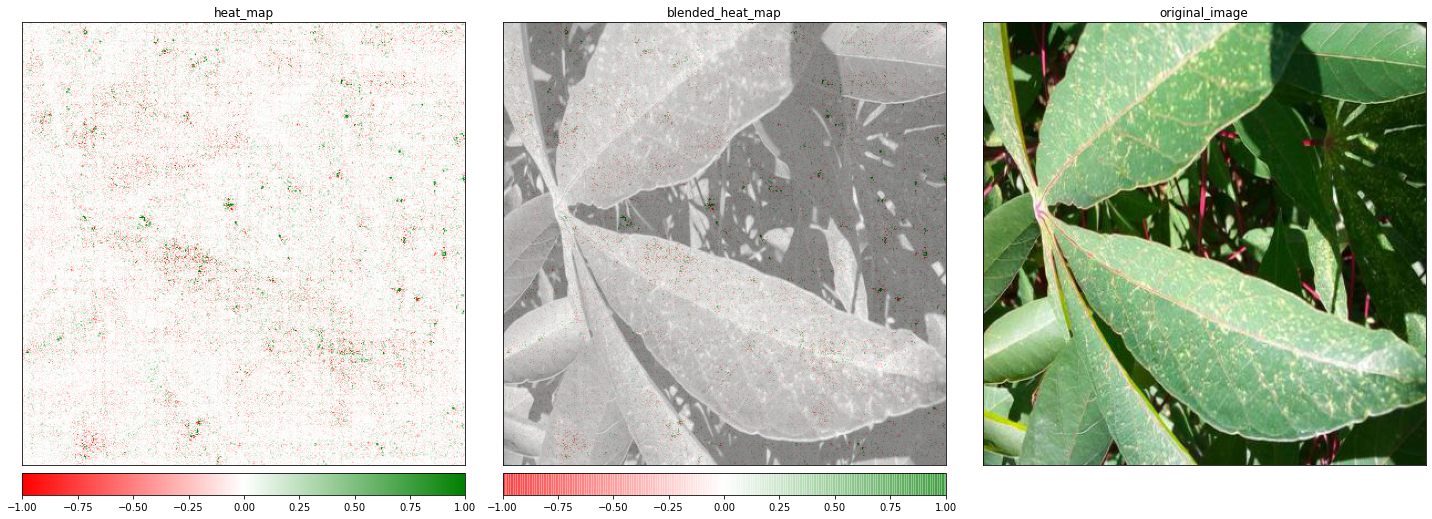

In [46]:
idx = np.random.choice(indices_2019_test)
source = test.subset.dataset.sources[test.subset.indices][idx]
print(source)

image, label = test[idx]
prep_image = test_transforms(image)
target = int(label)

attribution = get_attribution(model, prep_image, source, label)

visualize_attribution(prep_image, attribution)


train_2020
True: train_2020
Pred: train_2020


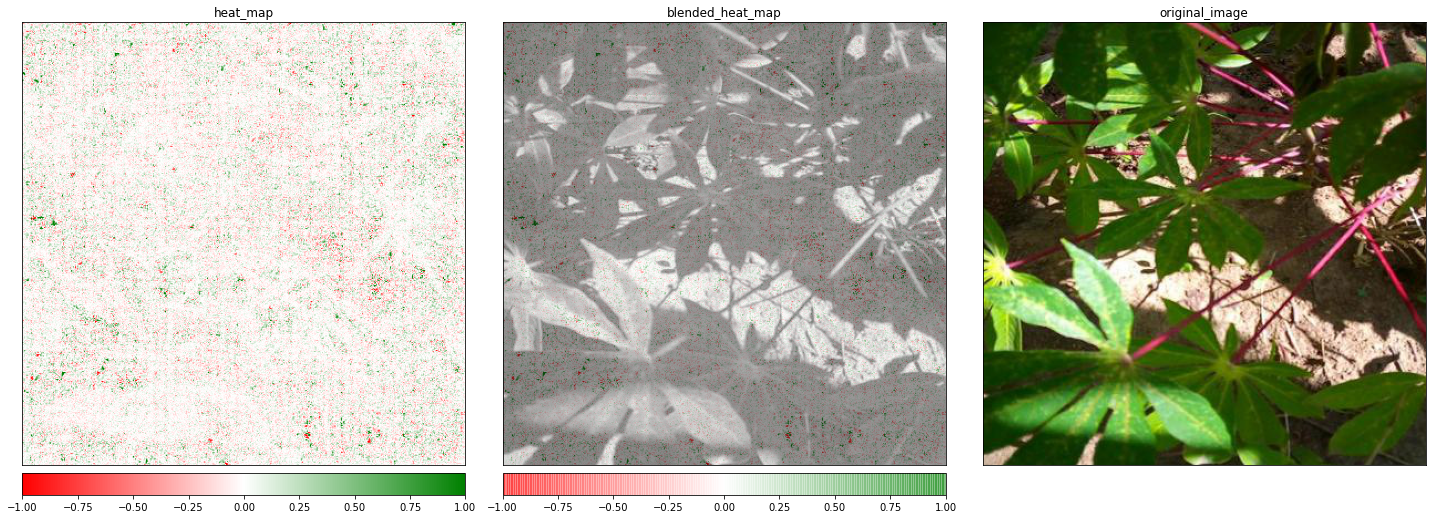

In [47]:
idx = np.random.choice(indices_2020_test)
source = test.subset.dataset.sources[test.subset.indices][idx]
print(source)

image, label = test[idx]
prep_image = test_transforms(image)
target = int(label)

attribution = get_attribution(model, prep_image, source, label)

visualize_attribution(prep_image, attribution)